# --- Project Name

# 1. Importing Libraries

In [235]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
%matplotlib inline

#pd.options.display.max_seq_items  = 4000
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# 2. Reading Files

###  2.1. Reading '.csv' Files

We will read each file into a pandas dataframe, and then store all the dataframes in a dictionary for easier access.

In [236]:
main_folder = "../data/schoolData"
csv_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

def read_csv_files(file_names):
    for file_name in file_names:
        path = "{0}/{1}".format(main_folder, file_name)
        key_name = remove_extension(file_name)
        data[key_name] = pd.read_csv(path)         
        print('The shape of {0} is : '.format(key_name), data[key_name].shape)
        
def remove_extension(file_name):
    return file_name.split(".")[0]
    
read_csv_files(csv_files)

The shape of ap_2010 is :  (258, 5)
The shape of class_size is :  (27611, 16)
The shape of demographics is :  (10075, 38)
The shape of graduation is :  (25096, 23)
The shape of hs_directory is :  (435, 64)
The shape of sat_results is :  (478, 6)


### 2.2 Reading '.txt' Files

In [237]:
txt_files = [
    "survey_all.txt",
    "survey_d75.txt"
]

def read_txt_files(file_names):
    result=[]   
    for file_name in file_names:
        path = '{0}/{1}'.format(main_folder, file_name)        
        content = pd.read_csv(path, delimiter = '\t', encoding = 'windows-1252')
        print('The shape of {0} is : '.format(file_name), content.shape)
        result.append(content)
    return result


data['survey'] = pd.concat(read_txt_files(txt_files), axis=0, sort=False)

print('The shape of survey is : ', data['survey'].shape)

The shape of survey_all.txt is :  (56, 1773)
The shape of survey_d75.txt is :  (1646, 1942)
The shape of survey is :  (1702, 2773)


# 3. Cleaning Data

### 3.1 Cleaning Survey Data

There are nearly over 2000 columns which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.

We will check the data dictionary to determine which features necessary for us.

https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8



In [238]:
relevant_survey_columns = ["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11",
                        "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", 
                        "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11",
                        "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

def rename_column(data, new_name, old_name):
    data[new_name] = data[old_name]
    data = data.drop("dbn", axis=1)
    return data

data['survey'] = data['survey'].loc[:,relevant_survey_columns]
data["survey"] = rename_column(data['survey'], "DBN", "dbn")
print('The shape of survey is :', data['survey'].shape, 'after removing unnecessary columns')

The shape of survey is : (1702, 23) after removing unnecessary columns


### 3.2 Editing ''DBN'' columns

In [239]:
def show_quick_heads(data):
    for key,value in data.items():
        print('Key :',key)
        print(value.head(5))
        
show_quick_heads(data)

Key : ap_2010
      DBN                             SchoolName  AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.             39.0   
1  01M450                 EAST SIDE COMMUNITY HS             19.0   
2  01M515                    LOWER EASTSIDE PREP             24.0   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH            255.0   
4  02M296  High School of Hospitality Management              NaN   

   Total Exams Taken  Number of Exams with scores 3 4 or 5  
0               49.0                                  10.0  
1               21.0                                   NaN  
2               26.0                                  24.0  
3              377.0                                 191.0  
4                NaN                                   NaN  
Key : class_size
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 0

When we explored all of the data sets, we notice that each data set appears to either have a DBN column, or the information we need to create one. In order to combine data sets in a meaningful way, we will need  'DBN' column, that's why we need to edit 'DBN' columns.
* hd_directory data has a 'dbn' column that we will change into 'DBN'.
* class_size data hasn't  'DBN' column but we can create 'DBN' column by merging 'CSD' column with 'SCHOOL CODE' column.  But first, we have to pad the 'CSD' column with zero.

In [240]:
data['hs_directory'] = rename_column(data['hs_directory'], "DBN", "dbn")

In [241]:
def pad_column(data,pad_length):
    return data.apply(lambda x: str(x).zfill(2))
    
data["class_size"]["DBN"] = pad_column(data["class_size"]["CSD"],2) + data["class_size"]["SCHOOL CODE"]

### 3.3 Combining SAT Scores

We need to create a column that totals up the SAT scores for the different sections of the exam but, to do this, we have to change sat scores column's data types to numeric.

In [242]:
def change_dtypes_to_numeric(df,columns):
    for col in columns:
        df[col]= pd.to_numeric(df[col], errors='coerce')   
    
    
to_be_changed_columns =[
    'SAT Math Avg. Score',
    'SAT Critical Reading Avg. Score',
    'SAT Writing Avg. Score']

change_dtypes_to_numeric(data['sat_results'],to_be_changed_columns )

In [243]:
data['sat_results']['sat_score'] = data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']

print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


### 3.4 Parsing Geographic Coordinates 

We will extract the coordinates from  Location 1 column in the hs_directory in order to map the school and uncover any geographic patterns in the data

In [244]:
data['hs_directory']['Location 1'].head()

0                     50 Avenue\nX Brooklyn, NY 11223\n(40.589238098, -73.981746524)
1               284 Baltic Street\nBrooklyn, NY 11201\n(40.685451806, -73.993491465)
2    45 35 Van Dam Street\nLong Island City, NY 11101\n(40.744149536, -73.933626741)
3             509 West 129 Street\nNew York, NY 10027\n(40.815230365, -73.955201206)
4          8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(40.601989336, -73.762834323)
Name: Location 1, dtype: object

In [245]:
def get_coordinate(loc):
    coord_pattern = "\(.+\)"
    return re.findall(coord_pattern, loc)

def get_lat(loc):
    coords = get_coordinate(loc)
    return pd.to_numeric(coords[0].split(",")[0].replace("(", "").strip())

def get_lon(loc):
    coords = get_coordinate(loc)
    return pd.to_numeric(coords[0].split(",")[1].replace(")", "").strip())
    
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(get_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(get_lon)

In [246]:
data["hs_directory"]

school_name  \
0                                                             John Dewey High School   
1                                                 Brooklyn School for Global Studies   
2                           International High School at LaGuardia Community College   
3                                  Academy for Social Action: A College Board School   
4                                          Frederick Douglass Academy VI High School   
5                                        Life Academy High School for Film and Music   
6                                     Frederick Douglass Academy IV Secondary School   
7                                                               Pablo Neruda Academy   
8               Fiorello H. LaGuardia High School of Music & Art and Performing Arts   
9                                  Urban Assembly Academy of Government and Law, The   
10                                            High School of Language and Innovation   
11                         Pathways in Technology Early College High School (P-Tech)   
12                                             Schuylerville Preparatory High School   
13                                     International High School for Health Sciences   
14                                                    Eagle Academy for Young Men II   
15                                              Humanities & Arts Magnet High School   
16                                                          Secondary School for Law   
17                                                          Forest Hills High School   
18                  Archimedes Academy for Math, Science and Technology Applications   
19                                Chelsea Career and Technical Education High School   
20                                                   Young Women's Leadership School   
21                                                         Bronx Compass High School   
22                                           Young Women's Leadership School, Queens   
23                                                        East Side Community School   
24                                                  Channel View School for Research   
25                                                    Victory Collegiate High School   
26                                             Urban Assembly New York Harbor School   
27                                         East-West School of International Studies   
28                                          High School for Media and Communications   
29                                High School for Public Service: Heroes of Tomorrow   
30                              World Journalism Preparatory: A College Board School   
31                     Queens High School of Teaching, Liberal Arts and the Sciences   
32                                                                Beacon High School   
33                                                      East New York Family Academy   
34                 Riverdale / Kingsbridge Academy (Middle School / High School 141)   
35                                                                       Bronx Latin   
36                                                           Frances Perkins Academy   
37                                                 Bronx Health Sciences High School   
38                      Inwood Early College for Health and Information Technologies   
39                                Queens Gateway to Health Sciences Secondary School   
40                                        Academy for Careers in Television and Film   
41                                            High School for Law and Public Service   
42                                                              Heritage School, The   
43                                             Franklin Delano Roosevelt High School   
44                                                          Clara Barton High School   
45                       

### 3.5 Condensing Datasets

This is a very important step because, we noticed that the values in the DBN column are unique in the sat_results that is the main dataset but some of the other datasets have duplicate DBN values.  We'll need to condense these data sets so that each value in the DBN column is unique.

In [247]:
def check_the_column_unique(df,df_name,col):
    if df.shape[0] == len(df[col].unique()):
        print('The {} dataset\'s {} column is unique.'.format(df_name,col))
    else :
        print('The {} dataset\'s {} column is not unique.'.format(df_name,col))
        
        
for key,value in data.items():
    check_the_column_unique(value,key,'DBN')

The ap_2010 dataset's DBN column is not unique.
The class_size dataset's DBN column is not unique.
The demographics dataset's DBN column is not unique.
The graduation dataset's DBN column is not unique.
The hs_directory dataset's DBN column is unique.
The sat_results dataset's DBN column is unique.
The survey dataset's DBN column is unique.


##### class_size

In [248]:
data['class_size'].head(10)

CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   
5    1       M        M015  P.S. 015 Roberto Clemente     02          CTT   
6    1       M        M015  P.S. 015 Roberto Clemente     03       GEN ED   
7    1       M        M015  P.S. 015 Roberto Clemente     03          CTT   
8    1       M        M015  P.S. 015 Roberto Clemente     04       GEN ED   
9    1       M        M015  P.S. 015 Roberto Clemente     05       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   
5                                    -                                   -   
6                                    -                                   -   
7                                    -                                   -   
8                                    -                                   -   
9                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \
0                           -                               19.0   
1                           -                               21.0   
2                           -                               17.0   
3                           -                               17.0   
4                           -                               15.0   
5                           -                               17.0   
6                           -                               12.0   
7                           -                               15.0   
8                           -                               26.0   
9                           -                               27.0   

   NUMBER OF SECTIONS  AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  \
0                 1.0                19.0                    19.0   
1                 1.0                21.0                    21.0   
2                 1.0                17.0                    17.0   
3                 1.0                17.0                    17.0   
4                 1.0                15.0                    15.0   
5                 1.0                17.0                    17.0   
6                 1.0                12.0                    12.0   
7                 1.0                15.0                    15.0   
8                 2.0                13.0                    12.0   
9                 1.0                27.0                    27.0   

   SIZE OF LARGEST CLASS DATA SOURCE  SCHOOLWIDE PUPIL-TEACHER RATIO     DBN  
0                   19.0         ATS                             NaN  01M015  
1                   21.0         ATS                             NaN  01M015  
2                   17.0         ATS                             NaN  01M015  
3                   17.0         ATS                             NaN  01M015  
4                   15.0         ATS                             NaN  01M015  
5                   17.0         ATS                             NaN  01M015  
6                   12.0         ATS                             NaN  01M015  
7                   15.0         ATS                             NaN  01M015  
8                   14.0         ATS                             NaN  01M015

* Filter class_size so the GRADE  column only contains the value '09-12'
* Filter class_size so the PROGRAM TYPE  column only contains the value 'GEN ED'
* Filter the dataset to contain only one value per DBN/school
* Reset index to retain DBN as column

In [249]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head()

CSD BOROUGH SCHOOL CODE                                    SCHOOL NAME  \
225    1       M        M292  Henry Street School for International Studies   
226    1       M        M292  Henry Street School for International Studies   
227    1       M        M292  Henry Street School for International Studies   
228    1       M        M292  Henry Street School for International Studies   
229    1       M        M292  Henry Street School for International Studies   

    GRADE  PROGRAM TYPE CORE SUBJECT (MS CORE and 9-12 ONLY)  \
225  09-12       GEN ED                              ENGLISH   
226  09-12       GEN ED                              ENGLISH   
227  09-12       GEN ED                              ENGLISH   
228  09-12       GEN ED                              ENGLISH   
229  09-12       GEN ED                                 MATH   

    CORE COURSE (MS CORE and 9-12 ONLY) SERVICE CATEGORY(K-9* ONLY)  \
225                           English 9                           -   
226                          English 10                           -   
227                          English 11                           -   
228                          English 12                           -   
229                  Integrated Algebra                           -   

     NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
225                               63.0                 3.0   
226                               79.0                 3.0   
227                               38.0                 2.0   
228                               69.0                 3.0   
229                               53.0                 3.0   

     AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
225                21.0                    19.0                   25.0   
226                26.3                    24.0                   31.0   
227                19.0                    16.0                   22.0   
228                23.0                    13.0                   30.0   
229                17.7                    16.0                   21.0   

    DATA SOURCE  SCHOOLWIDE PUPIL-TEACHER RATIO     DBN  
225       STARS                             NaN  01M292  
226       STARS                             NaN  01M292  
227       STARS                             NaN  01M292  
228       STARS                             NaN  01M292  
229       STARS                             NaN  01M292

In [250]:
class_size['CORE SUBJECT (MS CORE and 9-12 ONLY)'].unique()

array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)

In [251]:
class_size['CORE COURSE (MS CORE and 9-12 ONLY)'].unique()

array(['English 9', 'English 10', 'English 11', 'English 12',
       'Integrated Algebra', 'Geometry', 'Other Math', 'Earth Science',
       'Living Environment', 'Chemistry', 'Physics', 'Other Science',
       'Global History & Geography', 'US History & Government',
       'MS English Core', 'Other English', 'Trigonometry',
       'Participation in Government', 'Math A', 'Economics',
       'Other Social Studies', 'Math B'], dtype=object)

Still, we don't have a unique 'DBN' column because of the 'CORE SUBJECT (MS CORE and 9-12 ONLY)' and 'CORE COURSE (MS CORE and 9-12 ONLY)' columns.  

We want our class size data to include every single class a school offers. What we can do is take the average across all of the classes a school offers. This will give us a unique DBN value.

In [252]:
class_size = class_size.groupby('DBN').agg(np.mean)

class_size.reset_index(inplace=True)

data['class_size'] = class_size
data['class_size'].head()

DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN

In [253]:
check_the_column_unique(data['class_size'],'class_size','DBN')

The class_size dataset's DBN column is unique.


#### demographics

In [254]:
data['demographics'].head(10)

DBN                                              Name  schoolyear  \
0  01M015                         P.S. 015 ROBERTO CLEMENTE    20052006   
1  01M015                         P.S. 015 ROBERTO CLEMENTE    20062007   
2  01M015                         P.S. 015 ROBERTO CLEMENTE    20072008   
3  01M015                         P.S. 015 ROBERTO CLEMENTE    20082009   
4  01M015                         P.S. 015 ROBERTO CLEMENTE    20092010   
5  01M015                         P.S. 015 ROBERTO CLEMENTE    20102011   
6  01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
7  01M019                               P.S. 019 ASHER LEVY    20052006   
8  01M019                               P.S. 019 ASHER LEVY    20062007   
9  01M019                               P.S. 019 ASHER LEVY    20072008   

  fl_percent  frl_percent  total_enrollment prek   k grade1 grade2 grade3  \
0       89.4          NaN               281   15  36     40     33     38   
1       89.4          NaN               243   15  29     39     38     34   
2       89.4          NaN               261   18  43     39     36     38   
3       89.4          NaN               252   17  37     44     32     34   
4                    96.5               208   16  40     28     32     30   
5                    96.5               203   13  37     35     33     30   
6        NaN         89.4               189   13  31     35     28     25   
7       61.5          NaN               402   15  43     55     53     68   
8       61.5          NaN               312   13  37     45     52     47   
9       61.5          NaN               338   28  48     46     47     53   

  grade4 grade5 grade6 grade7 grade8 grade9 grade10 grade11 grade12  ell_num  \
0     52     29     38    NaN    NaN    NaN     NaN     NaN     NaN     36.0   
1     42     46    NaN    NaN    NaN    NaN     NaN     NaN     NaN     38.0   
2     47     40    NaN    NaN    NaN    NaN     NaN     NaN     NaN     52.0   
3     39     49    NaN    NaN    NaN    NaN     NaN     NaN     NaN     48.0   
4     24     38    NaN    NaN    NaN    NaN     NaN     NaN     NaN     40.0   
5     30     25    NaN    NaN    NaN    NaN     NaN     NaN     NaN     30.0   
6     28     29                                                         20.0   
7     59     64     45    NaN    NaN    NaN     NaN     NaN     NaN     37.0   
8     61     57    NaN    NaN    NaN    NaN     NaN     NaN     NaN     30.0   
9     48     68    NaN    NaN    NaN    NaN     NaN     NaN     NaN     40.0   

   ell_percent  sped_num  sped_percent ctt_num selfcontained_num  asian_num  \
0         12.8      57.0          20.3      25                 9         10   
1         15.6      55.0          22.6      19                15         18   
2         19.9      60.0          23.0      20                14         16   
3         19.0      62.0          24.6      21                17         16   
4         19.2      46.0          22.1      14                14         16   
5         14.8      46.0          22.7      21                 9         13   
6         10.6      40.0          21.2      23                 7         12   
7          9.2      93.0          23.1       7                37         40   
8          9.6      72.0          23.1      13                22         30   
9         11.8      75.0          22.2      12                19         42   

   asian_per  black_num  black_per  hispanic_num  hispanic_per  white_num  \
0        3.6         74       26.3           189          67.3          5   
1        7.4         68       28.0           153          63.0          4   
2        6.1         77       29.5           157          60.2          7   
3        6.3         75       29.8           149          59.1          7   
4        7.7         67       32.2           118          56.7          6   
5        6.4         75       36.9           110          54.2          4   
6        6.3         63       33.3        

* Filter demographics so the schoolyear column only contains the value 20112012

In [255]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear']==20112012]
data['demographics'].head()

DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2 grade3  \
6         NaN         89.4               189   13   31     35     28     25   
13        NaN         61.5               328   32   46     52     54     52   
20        NaN         92.5               626   52  102    121     87     88   
27        NaN         99.7               401   14   34     38     36     45   
35        NaN         78.9               176   18   20     30     21     31   

   grade4 grade5 grade6 grade7 grade8 grade9 grade10 grade11 grade12  ell_num  \
6      28     29                                                         20.0   
13     46     46                                                         33.0   
20     85     91                                                        128.0   
27     28     40     55     55     56                                    34.0   
35     26     30                                                          6.0   

    ell_percent  sped_num  sped_percent ctt_num selfcontained_num  asian_num  \
6          10.6      40.0          21.2      23                 7         12   
13         10.1      59.0          18.0      16                16         51   
20         20.4      97.0          15.5      49                31        190   
27          8.5     106.0          26.4      59                16         22   
35          3.4      45.0          25.6      34                 4          9   

    asian_per  black_num  black_per  hispanic_num  hispanic_per  white_num  \
6         6.3         63       33.3           109          57.7          4   
13       15.5         81       24.7           158          48.2         28   
20       30.4         55        8.8           357          57.0         16   
27        5.5         90       22.4           275          68.6          8   
35        5.1         41       23.3           110          62.5         15   

    white_per  male_num  male_per  female_num  female_per  
6         2.1      97.0      51.3        92.0        48.7  
13        8.5     147.0      44.8       181.0        55.2  
20        2.6     330.0      52.7       296.0        47.3  
27        2.0     204.0      50.9       197.0        49.1  
35        8.5      97.0      55.1        79.0        44.9

In [256]:
check_the_column_unique(data['demographics'],'demographics','DBN')

The demographics dataset's DBN column is unique.


#### graduation

In [257]:
data['graduation'].head(10)

Demographic     DBN                            School Name    Cohort  \
0  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2003   
1  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2004   
2  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2005   
3  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL      2006   
4  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL  2006 Aug   
5  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL      2001   
6  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL      2002   
7  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL      2003   
8  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL      2004   
9  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL      2005   

   Total Cohort Total Grads - n  Total Grads - % of cohort Total Regents - n  \
0             5               s                        NaN                 s   
1            55              37                       67.3                17   
2            64              43                       67.2                27   
3            78              43                       55.1                36   
4            78              44                       56.4                37   
5            64              46                       71.9                32   
6            52              33                       63.5                19   
7            87              67                       77.0                39   
8           112              75                       67.0                36   
9           121              64                       52.9                35   

   Total Regents - % of cohort  Total Regents - % of grads  \
0                          NaN                         NaN   
1                         30.9                        45.9   
2                         42.2                        62.8   
3                         46.2                        83.7   
4                         47.4                        84.1   
5                         50.0                        69.6   
6                         36.5                        57.6   
7                         44.8                        58.2   
8                         32.1                        48.0   
9                         28.9                        54.7   

  Advanced Regents - n  Advanced Regents - % of cohort  \
0                    s                             NaN   
1                    0                             0.0   
2                    0                             0.0   
3                    0                             0.0   
4                    0                             0.0   
5                    7                            10.9   
6                    8                            15.4   
7                   11                            12.6   
8                    6                             5.4   
9                    4                             3.3   

   Advanced Regents - % of grads Regents w/o Advanced - n  \
0                            NaN                        s   
1                            0.0                       17   
2                            0.0                       27   
3                            0.0                       36   
4                            0.0                       37   
5                           15.2                       25   
6                           24.2                       11   
7                           16.4                       28   
8                            8.0                       30   
9                            6.3                       31   

   Regents w/o Advanced - % of cohort  Regents w/o Advanced - % of grads  \
0                                 NaN                                NaN   
1                                30.9                               45.9   
2                                42.2                           

In [258]:
data['graduation']['Demographic'].value_counts()

Total Cohort                   2493
Special Education Students     2471
English Proficient Students    2471
General Education Students     2471
Male                           2412
Black                          2403
Female                         2397
Hispanic                       2385
English Language Learners      2036
Asian                          1780
White                          1777
Name: Demographic, dtype: int64

* Filter graduation, only selecting rows where the Cohort column equals 2006.
* Filter graduation, only selecting rows where the Demographic column equals Total Cohort.


In [259]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
data["graduation"].head()

Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n  Total Grads - % of cohort Total Regents - n  \
3             78              43                       55.1                36   
10           124              53                       42.7                42   
17            90              70                       77.8                67   
24            84              47                       56.0                40   
31           193             105                       54.4                91   

    Total Regents - % of cohort  Total Regents - % of grads  \
3                          46.2                        83.7   
10                         33.9                        79.2   
17                         74.4                        95.7   
24                         47.6                        85.1   
31                         47.2                        86.7   

   Advanced Regents - n  Advanced Regents - % of cohort  \
3                     0                             0.0   
10                    8                             6.5   
17                    0                             0.0   
24                   17                            20.2   
31                   69                            35.8   

    Advanced Regents - % of grads Regents w/o Advanced - n  \
3                             0.0                       36   
10                           15.1                       34   
17                            0.0                       67   
24                           36.2                       23   
31                           65.7                       22   

    Regents w/o Advanced - % of cohort  Regents w/o Advanced - % of grads  \
3                                 46.2                               83.7   
10                                27.4                               64.2   
17                                74.4                               95.7   
24                                27.4                               48.9   
31                                11.4                               21.0   

   Local - n  Local - % of cohort  Local - % of grads Still Enrolled - n  \
3          7                  9.0                16.3                 16   
10        11                  8.9                20.8                 46   
17         3                  3.3                 4.3                 15   
24         7                  8.3                14.9                 25   
31        14                  7.3                13.3                 53   

    Still Enrolled - % of cohort Dropped Out - n  Dropped Out - % of cohort  
3                           20.5              11                       14.1  
10                          37.1              20                       16.1  
17                          16.7               5                        5.6  
24                          29.8               5                        6.0  
31                          27.5              35                       18.1

In [260]:
check_the_column_unique(data['graduation'],'graduation','DBN')

The graduation dataset's DBN column is unique.


#### ap_2010

In [261]:
data['ap_2010']['DBN'].value_counts()

04M610    2
02M400    1
28Q687    1
11X542    1
10X368    1
02M630    1
01M539    1
02M625    1
31R080    1
01M450    1
10X243    1
19K659    1
13K483    1
28Q505    1
27Q475    1
17K546    1
32K552    1
31R445    1
19K507    1
21K348    1
07X520    1
27Q262    1
15K497    1
18K415    1
06M540    1
11X253    1
09X329    1
08X405    1
19K615    1
10X437    1
07X221    1
22K405    1
02M412    1
02M600    1
10X546    1
09X414    1
26Q495    1
21K344    1
09X231    1
07X600    1
14K488    1
02M305    1
01M448    1
06M462    1
19K660    1
13K509    1
09X365    1
11X513    1
09X276    1
17K528    1
03M415    1
02M551    1
12X690    1
25Q525    1
27Q400    1
19K409    1
12X682    1
10X696    1
13K412    1
18K500    1
10X213    1
07X547    1
02M520    1
01M515    1
14K685    1
17K625    1
11X299    1
09X525    1
20K490    1
04M409    1
27Q323    1
21K400    1
22K535    1
30Q450    1
20K485    1
09X250    1
27Q480    1
24Q610    1
28Q470    1
28Q690    1
06M467    1
14K322    1
13K265    1
08X3

In [262]:
duplicated_dbn = data['ap_2010'][data['ap_2010']['DBN']=='04M610']
duplicated_dbn

DBN                                          SchoolName  \
51  04M610  THE YOUNG WOMEN'S LEADERSHIP SCHOOL OF EAST HARLEM   
52  04M610                        YOUNG WOMEN'S LEADERSHIP SCH   

    AP Test Takers   Total Exams Taken  Number of Exams with scores 3 4 or 5  
51             41.0               55.0                                  29.0  
52              NaN                NaN                                   NaN

In [263]:
data['ap_2010'] = data['ap_2010'][data['ap_2010'].SchoolName != "YOUNG WOMEN'S LEADERSHIP SCH"]

In [264]:
for key,value in data.items():
    check_the_column_unique(value,key,'DBN')

The ap_2010 dataset's DBN column is unique.
The class_size dataset's DBN column is unique.
The demographics dataset's DBN column is unique.
The graduation dataset's DBN column is unique.
The hs_directory dataset's DBN column is unique.
The sat_results dataset's DBN column is unique.
The survey dataset's DBN column is unique.


Now, all of the datasets have a unique 'DBN'  column that we will be able to use as an identifier for combining the data.  It means we can start combining data.

### 3.6 Combining Datasets

There may be DBN values ​​that exist in one data set but not in the other. Therefore, it is very important to choose the right merge strategy to avoid data loss as much as possible.
Each merge strategy has its advantages. Depending on the strategy we choose, we may preserve rows at the expense of having more missing column data or minimize missing data at the expense of having fewer rows. 

This project is concerned with determining demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from sat_results while minimizing null values.

In [265]:
for key in data:
    print('The shape of {0} is : '.format(key), data[key].shape)

The shape of ap_2010 is :  (257, 5)
The shape of class_size is :  (583, 8)
The shape of demographics is :  (1509, 38)
The shape of graduation is :  (405, 23)
The shape of hs_directory is :  (435, 66)
The shape of sat_results is :  (478, 7)
The shape of survey is :  (1702, 23)


'ap_2010' and the 'graduation' data sets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them.

In [266]:
combined = data["sat_results"]
combined = combined.merge(data['ap_2010'] , how='left',on='DBN')
combined = combined.merge(data['graduation'] , how='left',on='DBN')

print(combined.head())
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

The other data sets contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.

In [267]:
combined = combined.merge(data['class_size'] , how='inner',on='DBN')
combined = combined.merge(data['demographics'] , how='inner',on='DBN')
combined = combined.merge(data['survey'] , how='inner',on='DBN')
combined = combined.merge(data['hs_directory'] , how='inner',on='DBN')

combined.head()
print(combined.shape)

(362, 164)


### 3.7 Handling Missing Values 

In [268]:
combined.isnull().sum().sort_values(ascending=False)

fl_percent                              362
SCHOOLWIDE PUPIL-TEACHER RATIO          362
expgrade_span_min                       362
priority10                              362
priority09                              362
priority08                              362
expgrade_span_max                       361
priority07                              360
priority06                              350
priority05                              333
online_ap_courses                       309
online_language_courses                 307
school_type                             294
partner_financial                       291
priority04                              245
psal_sports_coed                        237
Number of Exams with scores 3 4 or 5    222
campus_name                             196
partner_other                           188
priority03                              179
partner_corporate                       179
partner_hospital                        179
addtl_info2                     

In [269]:
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)

### 3.8 Adding a School District Column for Mapping

In [270]:
combined['DBN'].head()

0    01M292
1    01M448
2    01M450
3    01M509
4    01M539
Name: DBN, dtype: object

In [271]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)
print(combined["school_dist"].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


 # 4. Data Analyzing & Visualizing

## 4.1 Finding Correlations

In [272]:
corr = combined.corr()
strong_corr = corr[corr['sat_score'].abs() > 0.30]['sat_score'].sort_values(ascending=False) 

In [273]:
print(corr['sat_score'].sort_values(ascending=False))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987835
SAT Critical Reading Avg. Score         0.986821
SAT Math Avg. Score                     0.972664
Advanced Regents - % of cohort          0.771787
Advanced Regents - % of grads           0.740406
Total Regents - % of cohort             0.667920
white_per                               0.621986
Total Grads - % of cohort               0.585014
asian_per                               0.571624
AP Test Takers                          0.523383
Total Exams Taken                       0.514572
Total Regents - % of grads              0.494469
asian_num                               0.476277
Number of Exams with scores 3 4 or 5    0.463458
white_num                               0.450429
N_s                                     0.424319
N_p                                     0.421948
total_students                          0.408762
NUMBER OF STUDENTS / SEATS FILLED       0.395932
female_num          

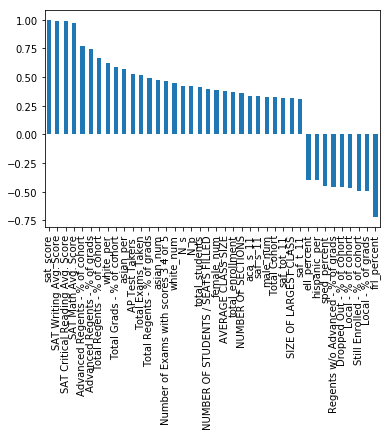

In [274]:
strong_corr.plot.bar()
plt.show()

* Unsurprisingly, 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score', and 'sat_score' are strongly correlated with sat_score.

* 'total_enrollment' has a strong positive correlation with 'sat_score'. 

* Other columns that are related to enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.

* Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively

* There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).

* The percentage of English language learners at the school (ell_percent) has a strong negative correlation with SAT scores.


#### Plotting survey correlations

In [275]:
relevant_survey_columns.remove('dbn')

In [276]:
survey_corr = combined.corr()['sat_score'][relevant_survey_columns].sort_values(ascending=False)
survey_corr

N_s           0.424319
N_p           0.421948
aca_s_11      0.338242
saf_s_11      0.336485
saf_tot_11    0.317442
saf_t_11      0.312497
N_t           0.292384
rr_s          0.231890
eng_s_11      0.212497
aca_tot_11    0.189005
com_s_11      0.186068
aca_t_11      0.130313
saf_p_11      0.121469
eng_tot_11    0.098118
com_t_11      0.080251
com_tot_11    0.074869
rr_p          0.046779
eng_t_11      0.034650
aca_p_11      0.033644
eng_p_11      0.019273
rr_t         -0.024694
com_p_11     -0.116765
Name: sat_score, dtype: float64

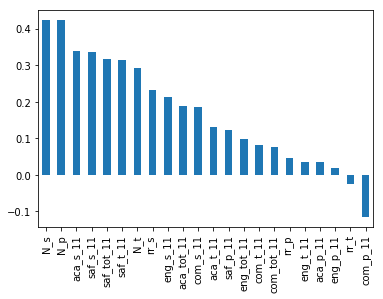

In [277]:
survey_corr.plot.bar()
plt.show()

‘p’ = parents, 't' = teachers, 's' = students

* There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

* According to the plot above, it is seen that the security understanding of teachers and students is different from that of parents. (saf_s_11, saf_t_11, saf_p_11)

## Exploring Total Enrolment And SAT Scores

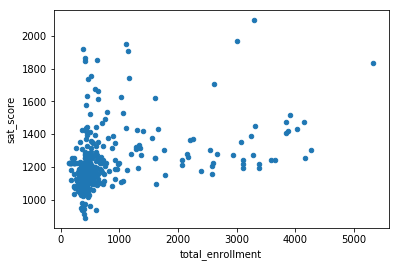

In [278]:
combined.plot.scatter(x='total_enrollment', y='sat_score')

 It doesn't appear that there's an extremely strong correlation between sat_score and total_enrollment. However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high.

In [279]:
low_enrollment = combined[(combined['sat_score']<1000)&(combined['total_enrollment']<1000)]
print(low_enrollment[['School Name','ell_percent']])

                               School Name  ell_percent
90     INTERNATIONAL COMMUNITY HIGH SCHOOL         90.1
124                                      0         86.6
125        BRONX INTERNATIONAL HIGH SCHOOL         87.1
138  KINGSBRIDGE INTERNATIONAL HIGH SCHOOL         88.7
140  INTERNATIONAL SCHOOL FOR LIBERAL ARTS         79.9
175                                      0         92.9
178          HIGH SCHOOL OF WORLD CULTURES         86.4
187     BROOKLYN INTERNATIONAL HIGH SCHOOL         83.1
224  INTERNATIONAL HIGH SCHOOL AT PROSPECT         91.0
236             IT TAKES A VILLAGE ACADEMY         30.4
252              MULTICULTURAL HIGH SCHOOL         94.6
285  PAN AMERICAN INTERNATIONAL HIGH SCHOO         91.3


When we examine schools with low SAT scores and low enrollment rates, we see that most of them are international schools. This leads us to  more detailed research in international schools.

In [280]:
inetnational_schools = combined[combined['School Name'].str.contains(pat='INTERNATIONAL',flags=re.IGNORECASE, na=False )]
inetnational_schools

DBN                                               SCHOOL NAME  \
0    01M292             HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
36   02M459                       MANHATTAN INTERNATIONAL HIGH SCHOOL   
83   06M462        HIGH SCHOOL FOR INTERNATIONAL BUSINESS AND FINANCE   
90   07X334                       INTERNATIONAL COMMUNITY HIGH SCHOOL   
125  09X403                           BRONX INTERNATIONAL HIGH SCHOOL   
138  10X268                     KINGSBRIDGE INTERNATIONAL HIGH SCHOOL   
140  10X342                     INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
187  13K439                        BROOKLYN INTERNATIONAL HIGH SCHOOL   
214  15K497                          SCHOOL FOR INTERNATIONAL STUDIES   
224  17K524             INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS   
264  21K337                    INTERNATIONAL HIGH SCHOOL AT LAFAYETTE   
285  24Q296                    PAN AMERICAN INTERNATIONAL HIGH SCHOOL   
290  24Q530  INTERNATIONAL HIGH SCHOOL AT LAGUARDIA COMMUNITY COLLEGE   
296  25Q263                        FLUSHING INTERNATIONAL HIGH SCHOOL   
297  25Q281                 EASTsWEST SCHOOL OF INTERNATIONAL STUDIES   
346  31R047                 CSI HIGH SCHOOL FOR INTERNATIONAL STUDIES   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                       29                            355.0   
36                      49                            376.0   
83                      76                            365.0   
90                      34                            310.0   
125                     49                            314.0   
138                     52                            304.0   
140                     49                            300.0   
187                     90                            305.0   
214                     64                            405.0   
224                     71                            287.0   
264                     54                            326.0   
285                     55                            317.0   
290                     69                            326.0   
296                     45                            314.0   
297                     59                            416.0   
346                    137                            452.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                  404.0                   363.0     1122.0   
36                 460.0                   391.0     1227.0   
83                 384.0                   378.0     1127.0   
90                 324.0                   311.0      945.0   
125                312.0                   339.0      965.0   
138                356.0                   302.0      962.0   
140                333.0                   301.0      934.0   
187                364.0                   312.0      981.0   
214                415.0                   392.0     1212.0   
224                335.0                   291.0      913.0   
264                386.0                   314.0     1026.0   
285                323.0                   311.0      951.0   
290                409.0                   329.0     1064.0   
296                417.0                   318.0     1049.0   
297                463.0                   392.0     1271.0   
346                451.0                   450.0     1353.0   

                                SchoolName  AP Test Takers   \
0                                        0       129.028846   
36             CES-MANHATTAN INTERNATIONAL        12.000000   
83           H.S. INT'L BUSINESS & FINANCE       108.000000   
90                                       0       129.028846   
125                                      0       129.028846   
138  Kingsbridge International High School        32.000000   
140  International School for Liberal Arts        55.000000   
187                                      0       129.028846   
214           SCHOOL FOR INTERNATL.STUDIES        30.00

When we search these international schools from https://tools.nycenet.edu/guide/2019/ site, we discover that there are a lot of students with economic needs and there are also a lot of students who learn English. Let's move on to explore english learners and sat scores. 

## Exploring English Language Learners  And SAT Scores

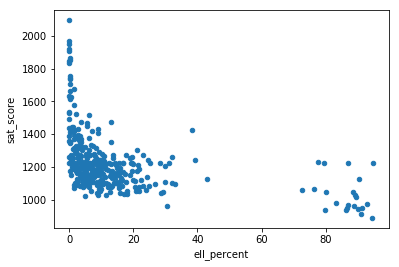

In [281]:
combined.plot.scatter(x='ell_percent', y='sat_score')

In [282]:
high_ell_percent = combined[combined['ell_percent'] >70 ]
high_ell_percent

DBN                                               SCHOOL NAME  \
31   02M427                     MANHATTAN ACADEMY FOR ARTS & LANGUAGE   
33   02M438                 INTERNATIONAL HIGH SCHOOL AT UNION SQUARE   
36   02M459                       MANHATTAN INTERNATIONAL HIGH SCHOOL   
44   02M542                             MANHATTAN BRIDGES HIGH SCHOOL   
88   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS   
90   07X334                       INTERNATIONAL COMMUNITY HIGH SCHOOL   
110  08X432                                 BRONX BRIDGES HIGH SCHOOL   
124  09X365                       ACADEMY FOR LANGUAGE AND TECHNOLOGY   
125  09X403                           BRONX INTERNATIONAL HIGH SCHOOL   
138  10X268                     KINGSBRIDGE INTERNATIONAL HIGH SCHOOL   
140  10X342                     INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
165  11X513                                     NEW WORLD HIGH SCHOOL   
175  12X388          PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE   
178  12X550                             HIGH SCHOOL OF WORLD CULTURES   
187  13K439                        BROOKLYN INTERNATIONAL HIGH SCHOOL   
224  17K524             INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS   
252  19K583                                 MULTICULTURAL HIGH SCHOOL   
264  21K337                    INTERNATIONAL HIGH SCHOOL AT LAFAYETTE   
285  24Q296                    PAN AMERICAN INTERNATIONAL HIGH SCHOOL   
290  24Q530  INTERNATIONAL HIGH SCHOOL AT LAGUARDIA COMMUNITY COLLEGE   
296  25Q263                        FLUSHING INTERNATIONAL HIGH SCHOOL   
343  30Q555                                     NEWCOMERS HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
31                       s                       404.035928   
33                       s                       404.035928   
36                      49                       376.000000   
44                      66                       336.000000   
88                      56                       339.000000   
90                      34                       310.000000   
110                      s                       404.035928   
124                     54                       315.000000   
125                     49                       314.000000   
138                     52                       304.000000   
140                     49                       300.000000   
165                     72                       332.000000   
175                     30                       321.000000   
178                     42                       304.000000   
187                     90                       305.000000   
224                     71                       287.000000   
252                     29                       279.000000   
264                     54                       326.000000   
285                     55                       317.000000   
290                     69                       326.000000   
296                     45                       314.000000   
343                    143                       323.000000   

     SAT Math Avg. Score  SAT Writing Avg. Score    sat_score  \
31            419.577844              399.517964  1223.131737   
33            419.577844              399.517964  1223.131737   
36            460.000000              391.000000  1227.000000   
44            378.000000              344.000000  1058.000000   
88            349.000000              326.000000  1014.000000   
90            324.000000              311.000000   945.000000   
110           419.577844              399.517964  1223.131737   
124           339.000000              297.000000   951.000000   
125           312.000000              339.000000   965.000000   
138           356.000000              302.000000   962.000000   
140           333.000000              301.000000   934.000000   
165           381.000000              335.000000  1048.000000   
175           351.000000         

There's  the cluster of schools in the right bottom that have very high ell_percent  and low sat_score values. This cluster represents the same group of international high schools we investigated earlier.



## Exploring Gender And SAT Scores

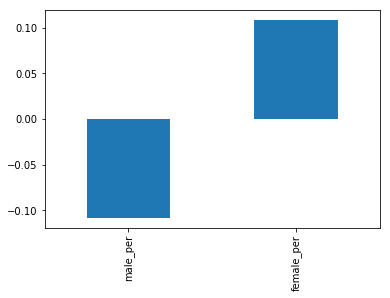

In [283]:
corr['sat_score'][['male_per', 'female_per']].plot.bar()

In the plot above, we can see that percentage of females at a school positively correlates with SAT score, whereas percentage of males at a school negatively correlates with SAT score. But, neither correlation is extremely strong.

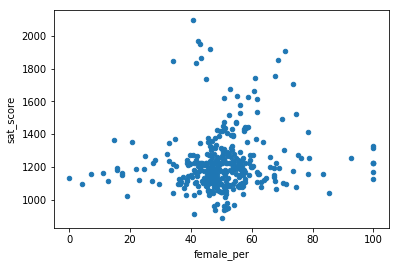

In [284]:
combined.plot.scatter("female_per", "sat_score")

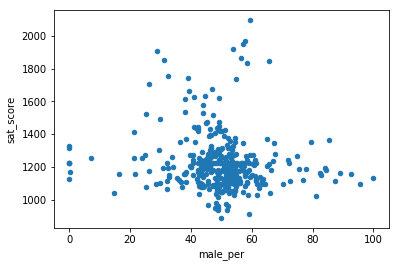

In [285]:
combined.plot.scatter("male_per", "sat_score")

We noticed that in schools where the female percentage is too high or too low, the SAT scores decrease. Of course, This is the case for male percentages too.

## Exploring Safety and SAT Scores

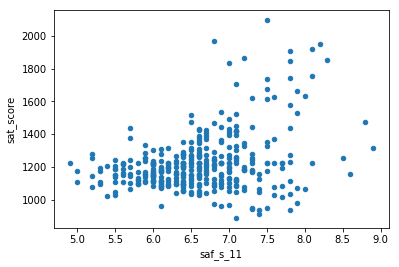

In [286]:
combined.plot.scatter('saf_s_11','sat_score')

In [303]:
high_sat_safety = combined[(combined['sat_score'] > 1500) & (combined['saf_s_11'] > 6.5)]
high_sat_safety

DBN  \
4    01M539   
5    01M696   
22   02M408   
23   02M411   
24   02M412   
26   02M416   
27   02M418   
37   02M475   
60   03M479   
61   03M485   
78   05M692   
150  10X445   
154  10X696   
186  13K430   
197  14K449   
277  22K535   
286  24Q299   
301  25Q525   
313  27Q323   
324  28Q680   
326  28Q687   
345  30Q580   
355  31R605   

                                                              SCHOOL NAME  \
4          NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH SCHOOL   
5                                          BARD HIGH SCHOOL EARLY COLLEGE   
22                               PROFESSIONAL PERFORMING ARTS HIGH SCHOOL   
23                                      BARUCH COLLEGE CAMPUS HIGH SCHOOL   
24                            N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES   
26                                          ELEANOR ROOSEVELT HIGH SCHOOL   
27                                                 MILLENNIUM HIGH SCHOOL   
37                                                 STUYVESANT HIGH SCHOOL   
60                                                     BEACON HIGH SCHOOL   
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS   
78   HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE   
150                                          BRONX HIGH SCHOOL OF SCIENCE   
154                     HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE   
186                                        BROOKLYN TECHNICAL HIGH SCHOOL   
197                                            BROOKLYN LATIN SCHOOL, THE   
277                        LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES   
286                                     BARD HIGH SCHOOL EARLY COLLEGE II   
301                                           TOWNSEND HARRIS HIGH SCHOOL   
313                                                     SCHOLARS' ACADEMY   
324                    QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SCHOOL   
326                   QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE   
345                             BACCALAUREATE SCHOOL FOR GLOBAL EDUCATION   
355                                   STATEN ISLAND TECHNICAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
4                      159                            522.0   
5                      130                            624.0   
22                      94                            509.0   
23                     104                            496.0   
24                     114                            537.0   
26                     127                            572.0   
27                     144                            528.0   
37                     832                            679.0   
60                     261                            577.0   
61                     531                            566.0   
78                     101                            605.0   
150                    731                            632.0   
154                     92                            636.0   
186                   1277                            587.0   
197                     72                            586.0   
277                    259                            524.0   
286                    155                            545.0   
301                    278                            621.0   
313                     89                            499.0   
324                     99                            513.0   
326                    121                            612.0   
345                     61                            524.0   
355                    227                            635.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
4                  574.0                   525.0     1621.0   
5                  604.0                   628.0     1856.0   
22                 490.0                   523.0     1522.0   
23                 563.0         

In [288]:
combined['school_dist'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

In [297]:
 combined.groupby('school_dist')[['saf_s_11','sat_score']].mean().sort_values(ascending=False,by='sat_score')

saf_s_11    sat_score
school_dist                       
22           7.025000  1450.500000
31           6.530000  1382.500000
26           6.760000  1377.600000
25           6.912500  1357.000000
01           6.768199  1354.500000
28           6.627273  1347.763201
30           7.033333  1326.347971
02           6.910608  1295.599800
03           6.716667  1293.366267
05           6.314286  1285.018820
20           7.120000  1273.626347
24           7.107692  1242.000000
13           6.407692  1237.163980
27           6.390000  1224.300000
10           6.577273  1222.227273
04           6.783333  1207.166667
21           6.390909  1206.284703
15           6.177778  1190.570193
29           6.075000  1181.891467
14           6.685714  1179.437981
11           6.186667  1165.000000
06           6.950000  1164.613174
17           6.007143  1161.428571
08           6.364472  1159.581383
23           6.233333  1157.333333
09           6.655000  1131.956587
07           6.800000  1128.846154
16           5.875000  1120.032934
32           6.766667  1119.500000
18           6.190909  1118.000000
19           6.150000  1103.833333
12           7.116667  1101.771956

## Exploring Regend Exam

In [299]:
len(combined[combined['Advanced Regents - % of cohort'] ==0])

56

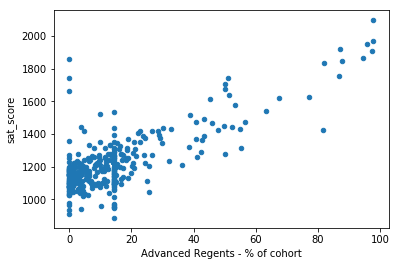

In [300]:
combined.plot.scatter(x='Advanced Regents - % of cohort', y='sat_score')

In [301]:
combined[(combined['Advanced Regents - % of grads'] < 20) & (combined['sat_score'] > 1600)]

DBN                        SCHOOL NAME Num of SAT Test Takers  \
5    01M696     BARD HIGH SCHOOL EARLY COLLEGE                    130   
60   03M479                 BEACON HIGH SCHOOL                    261   
286  24Q299  BARD HIGH SCHOOL EARLY COLLEGE II                    155   

     SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
5                              624.0                604.0   
60                             577.0                575.0   
286                            545.0                568.0   

     SAT Writing Avg. Score  sat_score     SchoolName  AP Test Takers   \
5                     628.0     1856.0              0       129.028846   
60                    592.0     1744.0  BEACON SCHOOL       166.000000   
286                   550.0     1663.0              0       129.028846   

     Total Exams Taken  Number of Exams with scores 3 4 or 5   Demographic  \
5           197.038462                                153.45  Total Cohort   
60          197.000000                                140.00  Total Cohort   
286         197.038462                                153.45  Total Cohort   

                           School Name Cohort  Total Cohort Total Grads - n  \
5       BARD HIGH SCHOOL EARLY COLLEGE   2006         139.0             134   
60                  BEACON HIGH SCHOOL   2006         269.0             259   
286  BARD HIGH SCHOOL EARLY COLLEGE II   2006          50.0              48   

     Total Grads - % of cohort Total Regents - n  Total Regents - % of cohort  \
5                         96.4               134                         96.4   
60                        96.3               247                         91.8   
286                       96.0                48                         96.0   

     Total Regents - % of grads Advanced Regents - n  \
5                         100.0                    0   
60                         95.4                    0   
286                       100.0                    0   

     Advanced Regents - % of cohort  Advanced Regents - % of grads  \
5                               0.0                            0.0   
60                              0.0                            0.0   
286                             0.0                            0.0   

    Regents w/o Advanced - n  Regents w/o Advanced - % of cohort  \
5                        134                                96.4   
60                       247                                91.8   
286                       48                                96.0   

     Regents w/o Advanced - % of grads Local - n  Local - % of cohort  \
5                                100.0         0                  0.0   
60                                95.4        12                  4.5   
286                              100.0         0                  0.0   

     Local - % of grads Still Enrolled - n  Still Enrolled - % of cohort  \
5                   0.0                  4                           2.9   
60                  4.6                  9                           3.3   
286                 0.0                  1                           2.0   

    Dropped Out - n  Dropped Out - % of cohort  CSD  \
5                 1                        0.7    1   
60                0                        0.0    3   
286               0                        0.0   24   

     NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
5                           214.166667           10.250000   
60                          355.333333           11.666667   
286                         176.571429            8.571429   

     AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
5             20.975000               17.166667              24.250000   
60            30.783333               26.083333              33.666667   
286           20.471429               16.071429              24.000000   

     SCHOOLWIDE PUPIL-TEACHER RATIO  \
5                               0.0